In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Set paths
data_dir = "C:/Users/Otinwa Ayomide/Downloads/Dissertation/Banana Ripeness Classification.v4-augmented3x-modifiedclasses.folder"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/valid"
test_dir = f"{data_dir}/test"

# Parameters
img_size = (224, 224)
batch_size = 32

# Load dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)


Found 20000 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.
Found 800 files belonging to 4 classes.


In [3]:
from tensorflow.keras import models, Input

def basic_block(x, filters, stride=1, downsample=False):
    identity = x

    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

def build_resnet10(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Block 1
    x = basic_block(x, 64)

    # Block 2
    x = basic_block(x, 128, stride=2, downsample=True)

    # Block 3
    x = basic_block(x, 192, stride=2, downsample=True)

    # Block 4
    x = basic_block(x, 256, stride=2, downsample=True)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Create the student model
student = build_resnet10()
student.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 re_lu_7 (ReLU)                 (None, 7, 7, 256)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 256)    589824      ['re_lu_7[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 7, 7, 256)    49152       ['re_lu_6[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 7, 7, 256)   1024        ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 7, 7, 256)   1024        ['conv2d_11[0][0]']              
 ormalizat

In [4]:
student.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
    )

history = student.fit(train_dataset, epochs = 15, validation_data=val_dataset )

Epoch 1/15
625/625 [==============================] - 578s 919ms/step - loss: 0.3534 - accuracy: 0.8717 - val_loss: 2.2641 - val_accuracy: 0.4719
Epoch 2/15
625/625 [==============================] - 652s 1s/step - loss: 0.2293 - accuracy: 0.9185 - val_loss: 2.1090 - val_accuracy: 0.5987
Epoch 3/15
625/625 [==============================] - 621s 994ms/step - loss: 0.1814 - accuracy: 0.9348 - val_loss: 0.3118 - val_accuracy: 0.9050
Epoch 4/15
625/625 [==============================] - 590s 943ms/step - loss: 0.1575 - accuracy: 0.9450 - val_loss: 0.3440 - val_accuracy: 0.8850
Epoch 5/15
625/625 [==============================] - 549s 879ms/step - loss: 0.1326 - accuracy: 0.9531 - val_loss: 0.4989 - val_accuracy: 0.8500
Epoch 6/15
625/625 [==============================] - 552s 883ms/step - loss: 0.1096 - accuracy: 0.9614 - val_loss: 0.5203 - val_accuracy: 0.8637
Epoch 7/15
625/625 [==============================] - 548s 876ms/step - loss: 0.1031 - accuracy: 0.9640 - val_loss: 0.2206 - va

In [6]:
result = student.evaluate(test_dataset)
print(f"Accuracy of model {result[1]*100:.2f}%")

25/25 [==============================] - 4s 149ms/step - loss: 0.5991 - accuracy: 0.8562
Accuracy of model 85.62%


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       200
           1       0.98      0.64      0.77       200
           2       0.87      0.84      0.86       200
           3       0.99      0.95      0.97       200

    accuracy                           0.86       800
   macro avg       0.89      0.86      0.85       800
weighted avg       0.89      0.86      0.85       800



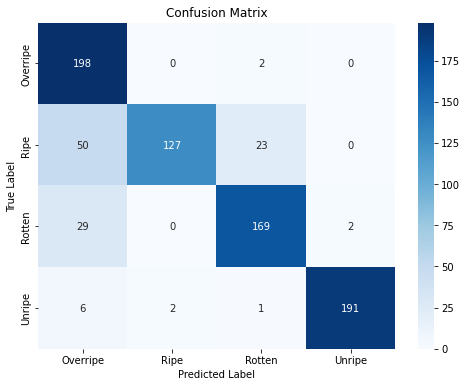

In [7]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Forward pass through student model (NOT distiller)
    logits = student(images, training=False)
    preds = tf.argmax(logits, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = ['Overripe', 'Ripe', 'Rotten', 'Unripe']

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
